# End-to-end test -- from a DSM to a DTM
with error/bias analysis

## Imports
### pytorch-unet

In [1]:
import os

if not os.path.exists("pytorch_unet.py"):
    if not os.path.exists("pytorch_unet"):
        !git clone https://github.com/akigoat/pytorch-unet.git

    # %cd pytorch-unet


fatal: destination path 'pytorch-unet' already exists and is not an empty directory.


In [2]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm, trange
import math
# files
import requests
from io import BytesIO
from zipfile import ZipFile
import os
import shutil
from pathlib import Path
# from scipy import interpolate
import matplotlib.pyplot as plt
# GIS
from osgeo import gdal
import rasterio
from affine import Affine
import richdem as rd
from rasterio.fill import fillnodata
# torch and dataset
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

# functions
import sys
sys.path.append('pytorch-unet')
import helper

import dataFunctions
import netClasses

In [3]:
try:
    device = torch.device("mps")
except:
    print("Check device")
    print("available: ", torch.backends.mps.is_available())
    print("built: ", torch.backends.mps.is_built())

In [4]:
from pathlib import Path
path_folder = '/Volumes/HydesT7/Grad Project/Data/U_Net/64_64_1_8_reselected/'
# path_folder = '/Users/hyde-mbp/Projects/Grad/data/64_64_1_8_rebuild/'
# path_model_folder = '/Users/hyde-mbp/Projects/Grad/model/0330/'
# path_model_folder = '/Volumes/HydesT7/Grad Project/Model/U_Net/1013/'
path_model_folder = '/Users/hyde-mbp/Projects/Grad/model/0405/'
path_ANH4 = '/Volumes/HydesT7/Grad Project/Data/AHN4_all/'
path_pre = '/Volumes/HydesT7/Grad Project/Data/AHN4_preprocessed_1_8/'

means = np.load(path_folder+'para_means.npy')
stds = np.load(path_folder+'para_stds.npy')

# dsm, aspect, slope, roughness, tpi, tri

# use the same transformations for train/val in this example
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([means[0], means[1], means[2]], [
                         stds[0], stds[1], stds[2]])  # imagenet
])

list_patch = []
with open(path_ANH4+'test_patchs.txt') as fp:
    # list_patch.append(patch)
    list_patch = [line.rstrip('\n') for line in fp]
# print(list_patch[:5], len(list_patch))

# Path("data/tmp").mkdir(parents=True, exist_ok=True)



In [5]:
display(means, stds)

array([9.90327775, 2.48690886, 1.35894729])

array([19.5961904 ,  2.92635182,  1.85182111])

In [6]:
# it = random.choice(list_patch)
from pathlib import Path
Path('results_reselected_new').mkdir(parents=True, exist_ok=True)
# with open('results/error_analysis.txt', 'w') as f:
#     f.write('')
f = open('results_reselected_new/error_analysis.txt', 'w')


In [7]:
def mergeImg(im_list, im_dict, mask=False):
    height = int(im_dict[list(im_dict)[-1]].split(',')[0].split(':')[1])
    width = int(im_dict[list(im_dict)[-1]].split(',')[1].split(':')[1])
    im_merged = np.zeros((height, width), dtype=np.float32)
    if not mask:
        ndv = 3.4028230607370965e+38
        im_merged = im_merged-ndv
    else:
        im_merged = im_merged+0.5
    for k in im_dict:
        h0 = int(im_dict[k].split(',')[0].split(':')[0])
        h1 = int(im_dict[k].split(',')[0].split(':')[1])
        w0 = int(im_dict[k].split(',')[1].split(':')[0])
        w1 = int(im_dict[k].split(',')[1].split(':')[1])
        if not mask:
            im_merged[h0:h1, w0:w1] = np.where(
                im_list[k] > im_merged[h0:h1, w0:w1], im_list[k], im_merged[h0:h1, w0:w1])
        else:
            im_merged[h0:h1, w0:w1] = np.where(abs(
                im_list[k]-0.5) > abs(im_merged[h0:h1, w0:w1]-0.5), im_list[k], im_merged[h0:h1, w0:w1])
    return im_merged


In [8]:
model = netClasses.ResNetUNet(2)
model = model.to(device)
# /Users/hyde-mbp/Projects/Grad/model/0330/dsm_rou_slo_30_1e-4.pt
model.load_state_dict(torch.load(path_model_folder+'30_1e-4.pt'))
model.eval()


/Users/hyde-mbp/mambaforge/envs/torG2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hyde-mbp/mambaforge/envs/torG2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from pathlib import Path
from sklearn.metrics import mean_squared_error

# path_model_folder = '/Users/hyde-mbp/Projects/Grad/model/0330/'
# Path(path_model_folder).mkdir(parents=True, exist_ok=True)

def errorAnalysis(path_ANH4, item, folder_out):
    # from pathlib import Path

    Path(os.path.join(folder_out, 'dsm')).mkdir(parents=True, exist_ok=True)
    Path(os.path.join(folder_out, 'dtm')).mkdir(parents=True, exist_ok=True)
    Path(os.path.join(folder_out, 'gt')).mkdir(parents=True, exist_ok=True)
    Path(os.path.join(folder_out, 'pred')).mkdir(parents=True, exist_ok=True)
    tmp_path = 'data/tmp/'
    xres = 30
    yres = 30
    resample_alg = 'average'

    cut_height = 64
    cut_width = 64

    Path(tmp_path).mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(tmp_path):
        file_path = os.path.join(tmp_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
    
    dsm = path_ANH4+'R5_'+item+'.TIF'
    dtm = path_ANH4+'M5_'+item+'.TIF'

    dsm30 = tmp_path+'R30_'+item+'.TIF'
    _ = gdal.Warp(dsm30, dsm, xRes=xres, yRes=yres, resampleAlg=resample_alg)
    _ = None

    with rasterio.open(dsm30) as src:
        profile = src.profile
        arr = src.read(1)
        arr_filled = fillnodata(arr, mask=src.read_masks(1),
                                smoothing_iterations=0)

    dsm30f = tmp_path+'R30_'+item+'_filled.TIF'
    with rasterio.open(dsm30f, 'w', **profile) as dest:
        dest.write_band(1, arr_filled)

    slope_ = tmp_path+'R30_'+item+'_slope.TIF'
    _ = gdal.DEMProcessing(slope_, dsm30f, 'slope', computeEdges=True)
    _ = None
    # if checkNodata(slope_):
    #     list_hasnodata.append(slope_)

    roughness_ = tmp_path+'R30_'+item+'_Roughness.TIF'
    _ = gdal.DEMProcessing(roughness_, dsm30f, 'Roughness', computeEdges=True)
    _ = None

    dtm30 = tmp_path+'M30_'+item+'.TIF'
    _ = gdal.Warp(dtm30, dtm, xRes=xres, yRes=yres, resampleAlg=resample_alg)
    _ = None

    dsm_slices = dataFunctions.sliceRisPic(dataFunctions.readTIFF(tmp_path, 'R30_'+item+'.TIF', masked=True), cut_width, cut_height)
    dtm_slices = dataFunctions.sliceRisPic(dataFunctions.readTIFF(tmp_path, 'M30_'+item+'.TIF', masked=True), cut_width, cut_height)
    dsm_fill_slices, dsm_dict = dataFunctions.sliceRisPic(dataFunctions.readTIFF(tmp_path, 'R30_'+item+'_filled.TIF'), cut_height, cut_width, dt=True)
    slope_slices = dataFunctions.sliceRisPic(dataFunctions.readTIFF(tmp_path, 'R30_'+item+'_slope.TIF'), cut_height, cut_width)
    roughness_slices = dataFunctions.sliceRisPic(dataFunctions.readTIFF(tmp_path, 'R30_'+item+'_Roughness.TIF'), cut_height, cut_width)
    # tpi_slices = dataFunctions.sliceRisPic(dataFunctions.readTIFF(tmp_path, 'R30_'+item+'_TPI.TIF'), cut_height, cut_width)

    Imgs_roughness = dataFunctions.stackPics(dsm_fill_slices, roughness_slices, slope_slices)
    # Imgs_tpi = dataFunctions.stackPics(dsm_fill_slices, slope_slices, tpi_slices)

    ground_truth_slices = []
    for nn in range(len(dsm_slices)):
        ground_truth_slices.append(dataFunctions.generateGroundTruth(dsm_slices[nn], dtm_slices[nn], 0.5))
    
    Masks = np.stack(ground_truth_slices)
    Masks = Masks.astype(np.float32)
    
    gt = []
    for mask in ground_truth_slices:
        gt.append(mask[1])
    gt_w = mergeImg(gt, dsm_dict, mask=True)


    test_dataset = netClasses.TestDataset2(Imgs_roughness, transform=trans)
    test_loader = DataLoader(test_dataset, batch_size=Imgs_roughness.shape[0],
                             shuffle=False, num_workers=0)

    inputs, labels = next(iter(test_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)


    pred = model(inputs)
    pred = torch.sigmoid(pred)
    pred = pred.data.cpu().numpy()
    threshold, upper, lower = 0.5, 1, 0
    pred = np.where(pred > threshold, upper, lower)

    pred_l1 = []
    for p in list(pred):
        pred_l1.append(p[1])
    pred_w = mergeImg(pred_l1, dsm_dict, mask=True)

    fig = plt.figure(figsize=(14, 13))
    rda_dsm30 = rd.LoadGDAL(dsm30)
    # display(rda.no_data)
    # rd.rdShow(rda)
    disparr_dsm30 = np.array(rda_dsm30, copy=True)
    disparr_dsm30[disparr_dsm30 > rda_dsm30.no_data/10] = np.nan
    vmin, vmax = np.nanpercentile(disparr_dsm30, [2, 98])

    dtm_re = rd.LoadGDAL(dsm30)

    # rd.SaveGDAL(os.path.join(folder_out, 'R30_'+item+'.TIF'), dsm_rd)
    
    # print(pred_w.shape)

    # dtm_rd = dsm_rd.copy()
    for i in range(pred_w.shape[0]):
        for j in range(pred_w.shape[1]):
            if pred_w[i][j] > 0.5:
                dtm_re[i][j] = dtm_re.no_data
                # print(dsm_rd[i][j])
    
    rd.SaveGDAL(os.path.join(tmp_path, 'DTM_'+item+'_re.TIF'), dtm_re)

    disparr_dtm_re = np.array(dtm_re, copy=True)
    disparr_dtm_re[disparr_dtm_re > dtm_re.no_data/10] = np.nan
    # rd.SaveGDAL(os.path.join(folder_out, 'DTM_'+item+'.TIF'), dsm_rd)
    
    ax1 = fig.add_subplot(321)
    im1 = ax1.imshow(disparr_dsm30, vmin=vmin, vmax=vmax, cmap='turbo')
    ax1.set_xlim()
    ax1.set_ylim()
    ax1.set_title('DSM')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    rda_dtm30 = rd.LoadGDAL(dtm30)
    # display(rda.no_data)
    # rd.rdShow(rda)
    disparr_dtm30 = np.array(rda_dtm30, copy=True)
    disparr_dtm30[disparr_dtm30 > rda_dtm30.no_data/10] = np.nan
    # vmin, vmax = np.nanpercentile(disparr_dtm30, [2, 98])

    ax2 = fig.add_subplot(322)
    im2 = ax2.imshow(disparr_dtm30, vmin=vmin, vmax=vmax, cmap='turbo')
    ax2.set_xlim()
    ax2.set_ylim()
    ax2.set_title('DTM')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')

    color = [[255, 197, 77], [83, 191, 157]]
    color = np.array(color)/255
    cmap = colors.ListedColormap(color)
    norm = colors.BoundaryNorm([0, 0.5, 1], 2, clip=True)
    ax3 = fig.add_subplot(323)
    im3 = ax3.imshow(gt_w, cmap=cmap, norm=norm)
    ax3.set_title('Ground Turth')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical', ticks=np.linspace(0, 1, 2))

    ax4 = fig.add_subplot(324)
    im4 = ax4.imshow(pred_w, cmap=cmap, norm=norm)
    ax4.set_title('Prediction')
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical', ticks=np.linspace(0, 1, 2))

    ax5 = fig.add_subplot(325)
    im5 = ax5.imshow(disparr_dtm_re, vmin=vmin, vmax=vmax, cmap='turbo')
    ax5.set_xlim()
    ax5.set_ylim()
    ax5.set_title('produced DTM')
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im5, cax=cax, orientation='vertical')

    with rasterio.open(os.path.join(tmp_path, 'DTM_'+item+'_re.TIF')) as src:
        profile = src.profile
        arr = src.read(1)
        arr_filled = fillnodata(arr, mask=src.read_masks(1), smoothing_iterations=0)

    dtm30ref = tmp_path+'M30_'+item+'_re_filled.TIF'  
    with rasterio.open(dtm30ref, 'w', **profile) as dest:
        dest.write_band(1, arr_filled)

    rda_dtm30ref = rd.LoadGDAL(dtm30ref)
    # display(rda.no_data)
    # rd.rdShow(rda)
    disparr_dtm30ref = np.array(rda_dtm30ref, copy=True)
    disparr_dtm30ref[disparr_dtm30ref > rda_dtm30ref.no_data/10] = np.nan
    # vmin, vmax = np.nanpercentile(disparr_dtm30, [2, 98])
    ax6 = fig.add_subplot(326)
    im6 = ax6.imshow(disparr_dtm30ref, vmin=vmin, vmax=vmax, cmap='turbo')
    ax6.set_xlim()
    ax6.set_ylim()
    ax6.set_title('generated and interpolated DTM')
    divider = make_axes_locatable(ax6)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')
    fig.set_size_inches(12, 18)
    plt.tight_layout()
    plt.savefig(os.path.join(folder_out, item+'_ana4.png'))
    extent1 = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(os.path.join(os.path.join(folder_out, 'dsm'),item+'.png'), bbox_inches=extent1.expanded(1.4, 1.1))
    extent2 = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(os.path.join(os.path.join(folder_out, 'dtm'),item+'.png'), bbox_inches=extent2.expanded(1.4, 1.1))
    extent3 = ax3.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(os.path.join(os.path.join(folder_out, 'gt'),item+'.png'), bbox_inches=extent3.expanded(1.4, 1.1))
    extent4 = ax4.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(os.path.join(os.path.join(folder_out, 'pred'),item+'.png'), bbox_inches=extent4.expanded(1.4, 1.1))
    extent5 = ax5.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(os.path.join(os.path.join(folder_out, 'dtm'),item+'_p.png'), bbox_inches=extent5.expanded(1.4, 1.1))
    extent6 = ax6.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(os.path.join(os.path.join(folder_out, 'dtm'),item+'_pf.png'), bbox_inches=extent6.expanded(1.4, 1.1))
    
    with rasterio.open(dtm30) as src:
        profile = src.profile
        arr = src.read(1)
        arr_filled = fillnodata(arr, mask=src.read_masks(1), smoothing_iterations=0)

    dtm30f = tmp_path+'M30_'+item+'_filled.TIF'  
    with rasterio.open(dtm30f, 'w', **profile) as dest:
        dest.write_band(1, arr_filled)

    rda_dtm30f = rd.LoadGDAL(dtm30f)
    disparr_dtm30f = np.array(rda_dtm30f, copy=True)
    disparr_dtm30f[disparr_dtm30f > rda_dtm30f.no_data/10] = np.nan

    rmse = math.sqrt(mean_squared_error(disparr_dtm30f, disparr_dtm30ref))
    # se = np.square(np.subtract(disparr_dtm30f, disparr_dtm30ref))
    
    error_count = 0
    acc_count = 0
    error_wrong_judge = 0
    error_missed = 0
    error_ele = 0
    bias_ele = []

    dsm_ = dataFunctions.readTIFF(tmp_path, 'R30_'+item+'.TIF', masked=True)
    dtm_ = dataFunctions.readTIFF(tmp_path, 'M30_'+item+'.TIF', masked=True)

    # for i in range(pred_w.shape[0]):
    #     for j in range(pred_w.shape[1]):
    #         if abs(pred_w[i][j]-gt_w[i][j]) > 0.1:
    #             error_count += 1
    #             if dsm_.mask[i][j] == True:
    #                 error_wrong_judge += 1
    #             elif dtm_.mask[i][j] == False:
    #                 error_missed += 1
    #             else:
    #                 error_ele += 1
    #                 bias_ele.append(dsm_.data[i][j]-dtm_.data[i][j])
    #         else:
    #             acc_count += 1
    threshold = 0.1

    # Select elements that satisfy the condition using boolean indexing
    mask_error = np.abs(pred_w - gt_w) > threshold
    mask_missing = dtm_.mask == True
    mask_wrong = dsm_.mask == True

    # Calculate error counts using boolean operations
    error_count = np.sum(mask_error)
    error_wrong_judge = np.sum(mask_error & mask_wrong)
    error_missed = np.sum(mask_error & mask_missing)
    error_ele = np.sum(mask_error & ~mask_wrong & ~mask_missing)
    bias_ele = (dsm_.data - dtm_.data)[mask_error & ~mask_wrong & ~mask_missing]

    # Calculate accuracy count using boolean operations
    acc_count = np.sum(~mask_error)


    # print('accuracy: ', acc_count/(pred_w.shape[0]*pred_w.shape[1]), 
    # '; errors: ', error_count, '; wrong judges: ', error_wrong_judge/error_count, 
    # '; missed: ', error_missed/error_count)

    with open(os.path.join(folder_out, 'error_analysis.txt'), 'a') as f:
        f.write(item+':'+'\n')
        f.write('accuracy: {0}%\n'.format(100*acc_count/(pred_w.shape[0]*pred_w.shape[1])))
        f.write('errors: {0} \n'.format(error_count))
        f.write('wrong judges: {0} - {1}%\n'.format(error_wrong_judge, 100*error_wrong_judge/error_count))
        f.write('missed: {0} - {1}%\n'.format(error_missed,
                100*error_missed/error_count))
        f.write('elevation bias: {0} - {1}%\n'.format(error_ele,
                100*error_ele/error_count))
        f.write('\n')

    plt.close()

    return [acc_count/(pred_w.shape[0]*pred_w.shape[1]), error_count, error_wrong_judge, error_missed, error_ele, bias_ele, rmse, pred_w]

In [14]:
_ = errorAnalysis(path_ANH4, '10EN2', 'results_nobias')

In [16]:
_[-1][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [18]:
pbar.close()

 12%|█▏        | 6/50 [00:16<02:02,  2.80s/it]


In [12]:
f = open('results_reselected_new/error_analysis.txt', 'w')
accuracy = []
errors_count = []
errors_wrong_judge = []
errors_missed = []
errors_ele = []
bias_ele = []
rmse = []
pbar = tqdm(total=len(list_patch))
for it in list_patch:
    # print(it)
    _ = errorAnalysis(path_ANH4, it, 'results_reselected_new')

    accuracy.append(_[0])
    errors_count.append(_[1])
    errors_wrong_judge.append(_[2])
    errors_missed.append(_[3])
    errors_ele.append(_[4])
    bias_ele.append(_[5])
    rmse.append(_[-1])
    pbar.update(1)
pbar.close()

100%|██████████| 50/50 [01:35<00:00,  1.91s/it]


In [14]:
list_patch[5]

'05HN1'

In [20]:
np.mean(rmse)

0.5933291803507722

In [93]:
mse

[0.03309638,
 0.029282372,
 0.0280443,
 0.1311715,
 0.056502234,
 0.052412353,
 0.031019816,
 0.068558976,
 0.13090855,
 0.043287653,
 0.047278937,
 0.054107603,
 0.035398327,
 0.026381202,
 0.031737898,
 0.11834069,
 0.059396144,
 0.056365978,
 0.29445666,
 0.11399119,
 0.057377215,
 0.078126274,
 0.099927254,
 0.035466842,
 0.03732207,
 0.14623466,
 0.100567356,
 0.10402282,
 0.069960974,
 0.36364007,
 0.051614225,
 0.06728845,
 0.015718138,
 0.015130932,
 0.06622268,
 0.018338969,
 0.024723936,
 0.017416809,
 0.014618426,
 0.021583984,
 0.017249731,
 0.034334105,
 0.19643909,
 0.037585888,
 0.10013861,
 0.045246508,
 0.06885205,
 0.16775179,
 0.025143515,
 0.12495276,
 0.05198827,
 0.20847467,
 0.25068843,
 0.05746877,
 0.09186558,
 0.242836,
 0.07556601,
 0.2555152,
 0.29498926,
 0.15157652,
 0.18943451,
 0.08802513,
 0.049607113,
 0.08351631,
 0.077976584,
 0.08957874,
 0.5338555,
 0.0812564,
 0.44695258,
 0.22987731,
 0.041207254,
 0.07389193,
 6.2535973,
 0.063748606,
 0.0702011

In [21]:
np.mean(accuracy)

0.9410761169967756

In [52]:
def dsm2dtm(dsm, folder_out):
    tmp_path = 'data/tmp/'
    xres = 30
    yres = 30
    resample_alg = 'average'

    cut_height = 64
    cut_width = 64

    Path(tmp_path).mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(tmp_path):
        file_path = os.path.join(tmp_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

    # dsm = path_ANH4+'R5_'+it+'.TIF'
    # dtm = path_ANH4+'M5_'+it+'.TIF'

    item = dsm.split('/')[-1].split('.')[-2].split('_')[-1]

    dsm30 = tmp_path+'R30_'+item+'.TIF'
    _ = gdal.Warp(dsm30, dsm, xRes=xres, yRes=yres, resampleAlg=resample_alg)
    _ = None

    with rasterio.open(dsm30) as src:
        profile = src.profile
        arr = src.read(1)
        arr_filled = fillnodata(arr, mask=src.read_masks(1),
                                smoothing_iterations=0)

    dsm30f = tmp_path+'R30_'+item+'_filled.TIF'
    with rasterio.open(dsm30f, 'w', **profile) as dest:
        dest.write_band(1, arr_filled)

    slope_ = tmp_path+'R30_'+item+'_slope.TIF'
    _ = gdal.DEMProcessing(slope_, dsm30f, 'slope', computeEdges=True)
    _ = None
    # if checkNodata(slope_):
    #     list_hasnodata.append(slope_)

    roughness_ = tmp_path+'R30_'+item+'_Roughness.TIF'
    _ = gdal.DEMProcessing(roughness_, dsm30f, 'Roughness', computeEdges=True)
    _ = None

    # dtm30 = tmp_path+'M30_'+it+'.TIF'
    # _ = gdal.Warp(dtm30, dtm, xRes=xres, yRes=yres, resampleAlg=resample_alg)
    # _ = None

    # dsm_slices = dataFunctions.sliceRisPic(dataFunctions.readTIFF(
    #     tmp_path, 'R30_'+it+'.TIF', masked=True), cut_width, cut_height)
    # dtm_slices = dataFunctions.sliceRisPic(dataFunctions.readTIFF(
    #     tmp_path, 'M30_'+it+'.TIF', masked=True), cut_width, cut_height)
    dsm_fill_slices, dsm_dict = dataFunctions.sliceRisPic(dataFunctions.readTIFF(
        tmp_path, 'R30_'+it+'_filled.TIF'), cut_height, cut_width, dt=True)
    slope_slices = dataFunctions.sliceRisPic(dataFunctions.readTIFF(
        tmp_path, 'R30_'+it+'_slope.TIF'), cut_height, cut_width)
    roughness_slices = dataFunctions.sliceRisPic(dataFunctions.readTIFF(
        tmp_path, 'R30_'+it+'_Roughness.TIF'), cut_height, cut_width)
    Imgs_roughness = dataFunctions.stackPics(
        dsm_fill_slices, roughness_slices, slope_slices)

    # ground_truth_slices = []
    # for nn in range(len(dsm_slices)):
    #     ground_truth_slices.append(
    #         dataFunctions.generateGroundTruth(dsm_slices[nn], dtm_slices[nn]))

    # Masks = np.stack(ground_truth_slices)
    # Masks = Masks.astype(np.float32)

    # gt = []
    # for mask in ground_truth_slices:
    #     gt.append(mask[1])
    # gt_w = mergeImg(gt, dsm_dict, mask=True)

    test_dataset = netClasses.TestDataset2(Imgs_roughness, transform=trans)
    test_loader = DataLoader(test_dataset, batch_size=Imgs_roughness.shape[0],
                             shuffle=False, num_workers=0)

    inputs, labels = next(iter(test_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)

    pred = model(inputs)
    pred = torch.sigmoid(pred)
    pred = pred.data.cpu().numpy()
    # threshold, upper, lower = 0.5, 1, 0
    # pred = np.where(pred > threshold, upper, lower)

    pred_l1 = []
    for p in list(pred):
        pred_l1.append(p[1])
    pred_w = mergeImg(pred_l1, dsm_dict, mask=True)

    threshold, upper, lower = 0.5, 1.0, 0.0
    pred_w = np.where(pred_w > threshold, upper, lower)

    dsm_rd = rd.LoadGDAL(dsm30)

    rd.SaveGDAL(os.path.join(folder_out, 'R30_'+item+'.TIF'), dsm_rd)
    
    print(pred_w.shape)

    # dtm_rd = dsm_rd.copy()
    for i in range(pred_w.shape[0]):
        for j in range(pred_w.shape[1]):
            if pred_w[i][j] > 0.5:
                dsm_rd[i][j] = dsm_rd.no_data
                # print(dsm_rd[i][j])
    
    rd.SaveGDAL(os.path.join(folder_out, 'DTM_'+item+'.TIF'), dsm_rd)

    return pred_w, dsm_rd

In [53]:
Path('outputs').mkdir(parents=True, exist_ok=True)

# it = random.choice(list_patch)
# print(it)

it = '21CZ1'

dsm = path_ANH4+'R5_'+it+'.TIF'
dsm30 = os.path.join('outputs', 'R30_'+it+'.TIF')
dtm = os.path.join('outputs', 'DTM_'+it+'.TIF')

pred_w, dsm_rd = dsm2dtm(dsm, 'outputs')

(208, 167)


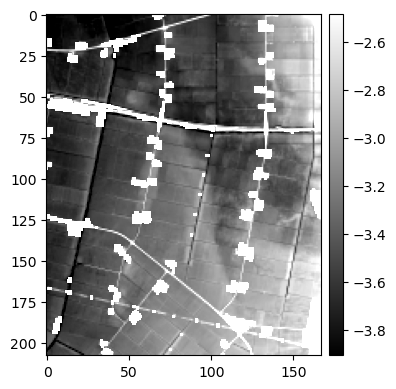

{'vmin': -3.9069467067718504, 'vmax': -2.4843797302246093}

In [54]:
rd.rdShow(dsm_rd)

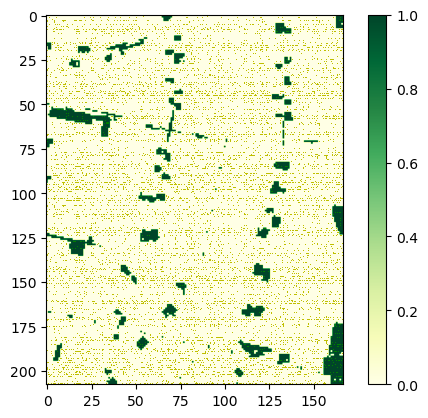

In [38]:
# import numpy as np
import matplotlib.pyplot as plt

# Create a 2D numpy array with 0s and 1s
# arr = np.array([[0, 1, 0], [1, 1, 0], [0, 1, 1]])

# Show the array using imshow
cmap = plt.get_cmap('YlGn')

# Set the color map for 0s to yellow and 1s to green
cmap.set_over('g')
cmap.set_under('y')

# Create a plot and show the image
plt.imshow(pred_w, cmap=cmap, vmin=0, vmax=1)
plt.colorbar()
plt.show()

# plt.imshow(pred_w, cmap='gray')



plt.show()

(208, 167)


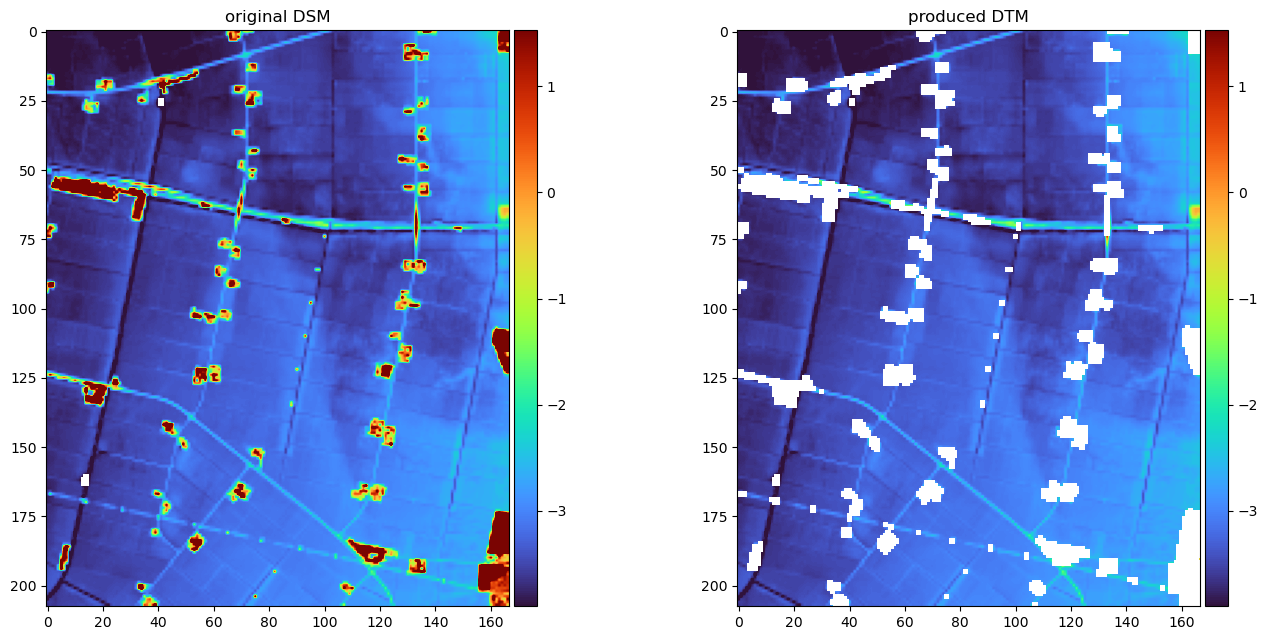

In [55]:
Path('outputs').mkdir(parents=True, exist_ok=True)

# it = random.choice(list_patch)
# print(it)

it = '21CZ1'

dsm = path_ANH4+'R5_'+it+'.TIF'
dsm30 = os.path.join('outputs', 'R30_'+it+'.TIF')
dtm = os.path.join('outputs', 'DTM_'+it+'.TIF')

dsm2dtm(dsm, 'outputs')

fig = plt.figure(figsize=(14, 6.5))

rda = rd.LoadGDAL(dsm30)
# display(rda.no_data)
# rd.rdShow(rda)
disparr = np.array(rda, copy=True)
disparr[disparr > rda.no_data/10] = np.nan
vmin, vmax = np.nanpercentile(disparr, [2, 98])

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(disparr, vmin=vmin, vmax=vmax, cmap='turbo')
ax1.set_xlim()
ax1.set_ylim()
ax1.set_title('original DSM')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

rda_ = rd.LoadGDAL(dtm)
# display(rda.no_data)
# rd.rdShow(rda)
disparr_ = np.array(rda_, copy=True)
disparr_[disparr_ > rda_.no_data/10] = np.nan
# vmin, vmax = np.nanpercentile(disparr_, [2, 98])

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(disparr_, vmin=vmin, vmax=vmax, cmap='turbo')
ax2.set_xlim()
ax2.set_ylim()
ax2.set_title('produced DTM')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# fig.colorbar(ax)
plt.tight_layout()
plt.show()

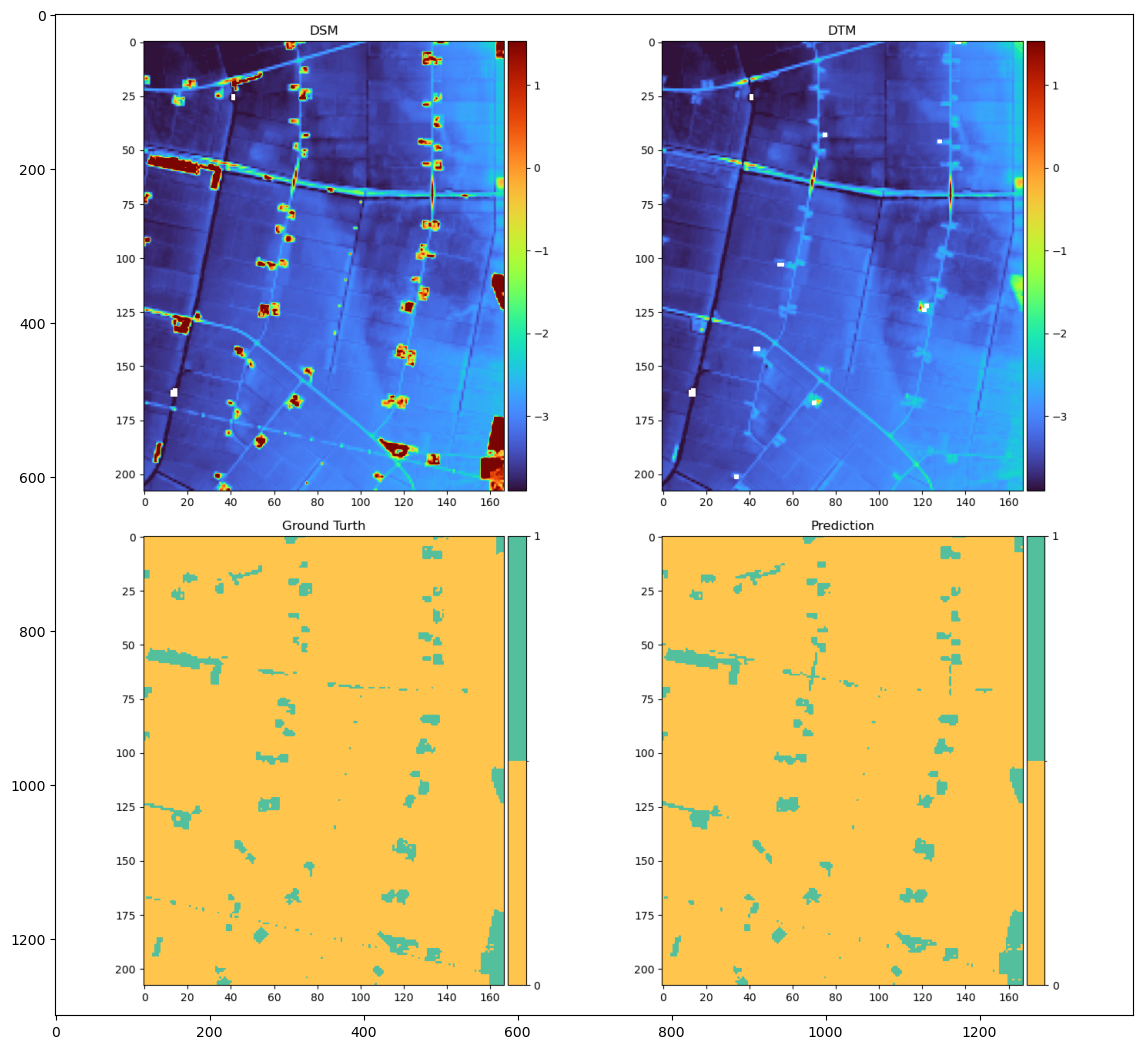

In [28]:
import matplotlib.image as mpimg
img = mpimg.imread(os.path.join('results', it+'_ana4.png'))
plt.figure(figsize=(14,13))
imgplot = plt.imshow(img)
plt.show()